# Titanic Survivors Prediction
---
<a id="background"></a>
### Background


In this project, I will use Python with **scikit-learn** to build a machine learning model (Random Forest Classifier), which use continuous and categorical data from [Kaggle (Titanic - Machine Learning from Disaster)](https://www.kaggle.com/competitions/titanic) to predict which passengers survived the Titanic shipwreck

**Random Forest Model** is an exceptionally useful machine learning method based on bagging different decision trees that split on a subset of features on each split.
The reasons I selected Random Forest for this project are:
1. It can handle binary, categorical, and numerical features. There is very little pre-processing that needs to be done - no need to be rescaled;
2. The computation process is parallelizable, meaning it's faster than boosted models which are sequential and would take longer to compute;
3. It is great with with high dimensional data;
4. It is robust to outliers and non-linear data;
5. More accurate with balancing bias and variance by averaging all the decision trees.

### Index

### [1. Background](#background)

### [2. Import modules and data](#import)

### [3. Data Exploration](#EDA)

### [4. Data Cleanse (Preprocessing)](#clean)

### [5. Feature Engineering](#feature)

### [6. Basic Model Building](#model)

### [7. Model Tuning](#tune)

### [8. Results & Explanation](#result)

`插入最终RF图`

<a id="import"></a>
# 2. Import modules and data
---

### i. Import necessary modules

The very first thing to do is load in a bunch of python modules. These modules give us extra functionality to import the data, clean it up and format it, and then build the models.

- numpy, pandas, Matplotlib, seaborn

In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

### ii. Import given data

Now we load in two datasets from Kaggle - the train dataset allows us to build and train machine learning model, the test dataset is used to predict if someone survived based on their sex, age, class and a variety of other metrics.

- [Train dataset](https://github.com/RaisetheMoon/Titanic-Survivors-Prediction/blob/main/raw%20data/train.csv)
- [Test dataset](https://github.com/RaisetheMoon/Titanic-Survivors-Prediction/blob/main/raw%20data/test.csv)

In [2]:
raw_train = pd.read_csv('https://raw.githubusercontent.com/RaisetheMoon/Titanic-Survivors-Prediction/main/raw%20data/train.csv')
raw_test = pd.read_csv('https://raw.githubusercontent.com/RaisetheMoon/Titanic-Survivors-Prediction/main/raw%20data/test.csv')

# make a copy of raw data so we can play around without touching original dataset
train = raw_train.copy()
test = raw_test.copy()

Now that we have loaded the training dataset into a dataframe called train, let's look at the first five rows using the `head()` function:

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### iii. Data dictionary

- Survived: 0 = No, 1 = Yes
- pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- cabin: Cabin number
- embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

<a id="EDA"></a>
# 3. Exploratory Data Analysis

Take a first glance at all data to learn about data shape, data types, missing values and basic statistics information. Then go ahead to understand the characteristics of each data by using histograms, box plots, etc.

---
### i. Overall info and description
- data types
- missing data
- statistics information

By applying `.info()`, we can see that there are **891 rows** and **12 columns** in our training dataset.

Also noticed that there're **12** columns in total including the **y** column 'Survived', which we're going to predict. In the 12 columns, there're **3** columns with NAs and `Cabin` has the most NAs (687); **7** columns are numeric and **5** columns are object which we need to transform later.

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  dataset_type  891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


### ii. Numeric and categorical columns
By applying `.describe()`, we can quickly get all numeric column names:

In [5]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

Calculate the **numbers of unique values** for all columns, then decide how to visualize these columns to observe their characteristics.

In [6]:
for i in train.columns:
    print(train[i].name,len(train[i].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


**Separate numeric and categorical columns** and assign them to `num_col` and `cat_col`. In this way we can apply different plot functions to them based on their attribution and get the result easily by using `for` loop.

In [7]:
num_col = train[['Age', 'SibSp', 'Parch', 'Fare']]
cat_col = train[['Survived','Pclass','Sex','Embarked']]

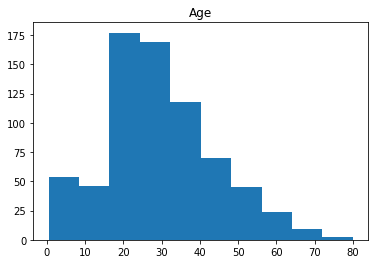

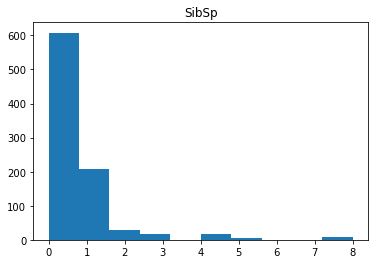

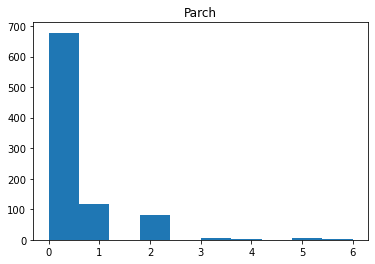

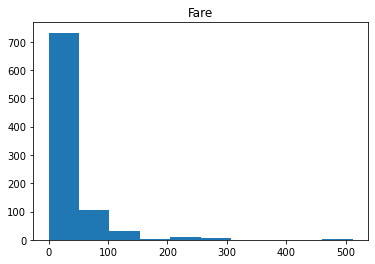

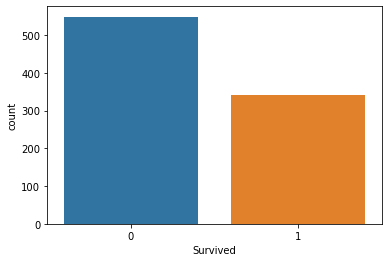

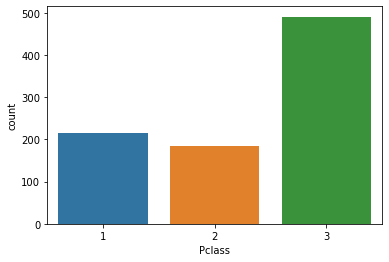

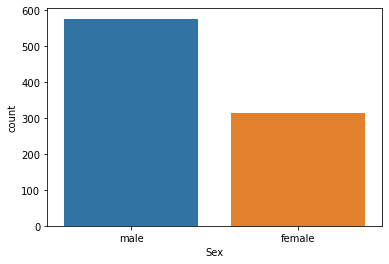

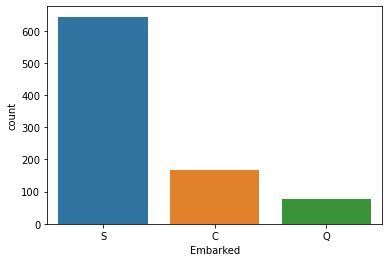

In [90]:


for i in num_col.columns:
    plt.hist(num_col[i])
    plt.title(i)
    plt.show()
for i in cat_col.columns:
    sns.countplot(cat_col[i])
    plt.show()

**Pivot** each column (feature) and explore the potential relationship between each category and its survival rate. 

For example, for column `Sex`, there's only 2 category - Male (**577**) and Female (**314**). **74%** females survived comparing to **19%** males even the total male count is greater than female. It is obvious that different sex has big impact on survive.

In [9]:
related_col = train[['Sex','SibSp', 'Parch','Pclass','Embarked']]
for i in related_col.columns:
    pivot = train.pivot_table(values='Survived',index = related_col[i], aggfunc=['count', np.mean])
    print(pivot)

          count      mean
       Survived  Survived
Sex                      
female      314  0.742038
male        577  0.188908
         count      mean
      Survived  Survived
SibSp                   
0          608  0.345395
1          209  0.535885
2           28  0.464286
3           16  0.250000
4           18  0.166667
5            5  0.000000
8            7  0.000000
         count      mean
      Survived  Survived
Parch                   
0          678  0.343658
1          118  0.550847
2           80  0.500000
3            5  0.600000
4            4  0.000000
5            5  0.200000
6            1  0.000000
          count      mean
       Survived  Survived
Pclass                   
1           216  0.629630
2           184  0.472826
3           491  0.242363
            count      mean
         Survived  Survived
Embarked                   
C             168  0.553571
Q              77  0.389610
S             644  0.336957


So far, with all the data we have analyzed, we can have a first bold guess - the ones who are: **female, with 1 sibling, with 1 parent, in first class, embark from C** has a relatively higher survival rate

But, how about those complicate data we haven't touched on?

### iii. Extract information from continuous data and complicate categorical data
 - **age:** `continuous` data
 - **name:** `891` unique values
 - **ticket:** `681` unique values
 - **fare:** `continous` data
 - **cabin:** `148` unique values

### a. Age: bag to different age groups

It's hard to identify patterns through specific age, so we need to split all people into 10 age groups.
Now we can see the highest survival rate is from 0-14 years old, which prove that children has first priority to board on the lifeboat

In [10]:
age_group = pd.qcut(train['Age'],10)
train.pivot_table('Survived',age_group)

,Survived
Age,
"(0.419, 14.0]",0.584416
"(14.0, 19.0]",0.390805
"(19.0, 22.0]",0.283582
"(22.0, 25.0]",0.371429
"(25.0, 28.0]",0.393443
"(28.0, 31.8]",0.393939
"(31.8, 36.0]",0.483516
"(36.0, 41.0]",0.358491
"(41.0, 50.0]",0.397436


### b. Name: title and length?
First, **extract title** from name to see if we can find any patterns.
From below table, I didn't see any patterns throughpeople with titles.

In [11]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
train.pivot_table(values='Survived',index = 'Name_Title', aggfunc=['count', np.mean])

,count,mean
,Survived,Survived
Name_Title,,
Capt.,1,0.000000
Col.,2,0.500000
Don.,1,0.000000
Dr.,7,0.428571
Jonkheer.,1,0.000000
Lady.,1,1.000000
Major.,2,0.500000
Master.,40,0.575000


Then, let's take a look if **length of name** has any impact on survival rate.
Luckily, there's a obvious relationship between them - longer names indeed have higher survival rate!

In [12]:
train['Name_Len'] = train['Name'].apply(lambda x: len(x))
len_group = pd.qcut(train['Name_Len'],5)
train.pivot_table('Survived',len_group, aggfunc=['count', np.mean])

,count,mean
,Survived,Survived
Name_Len,,
"(11.999, 19.0]",204,0.220588
"(19.0, 23.0]",156,0.301282
"(23.0, 27.0]",197,0.319797
"(27.0, 32.0]",165,0.442424
"(32.0, 82.0]",169,0.674556


### c. Fare: bag to different fare groups

Similar to `Age`, it'll be more clear if we assign fare into different groups.
Now we can see there's a obvious relationship between fare and survival rate - the higher fare is, the more likely the person will survive.

In [13]:
fare_group = pd.qcut(train['Fare'], 5)
train.pivot_table('Survived', fare_group, aggfunc=['count',np.mean])

,count,mean
,Survived,Survived
Fare,,
"(-0.001, 7.854]",179,0.217877
"(7.854, 10.5]",184,0.201087
"(10.5, 21.679]",172,0.424419
"(21.679, 39.688]",180,0.444444
"(39.688, 512.329]",176,0.642045


### d. Ticket: start with letter or number?

Take a glance at all ticket values, most of them start with numbers and some start with speicif letter. Let's extract first number/letter from ticket to take a next step look.

In [14]:
train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])
train.pivot_table(values='Survived',index = 'Ticket_Lett', aggfunc=['count', np.mean])

,count,mean
,Survived,Survived
Ticket_Lett,,
1,146,0.630137
2,183,0.464481
3,301,0.239203
4,10,0.200000
5,3,0.000000
6,6,0.166667
7,9,0.111111
8,2,0.000000


ticket start with 1, 2, F and P have higher survival rate

In [15]:
train.pivot_table(values='Fare',index = 'Ticket_Lett', aggfunc=['count', np.mean])

,count,mean
,Fare,Fare
Ticket_Lett,,
1,146,62.126797
2,183,19.903349
3,301,15.969611
4,10,15.893770
5,3,19.262500
6,6,14.711817
7,9,9.367133
8,2,8.397900


In [16]:
train.pivot_table(values='Pclass',index = 'Ticket_Lett', aggfunc=['count', np.mean])

,count,mean
,Pclass,Pclass
Ticket_Lett,,
1,146,1.184932
2,183,2.306011
3,301,2.890365
4,10,3.000000
5,3,2.333333
6,6,2.333333
7,9,3.000000
8,2,3.000000


船票格式和票价有线性关系，且船票太复杂只取票价即可

In [17]:
train['Cabin_Lett'] = train['Cabin'].apply(lambda x: str(x)[0])
train.pivot_table('Survived','Cabin_Lett', aggfunc=['count', np.mean])

,count,mean
,Survived,Survived
Cabin_Lett,,
A,15,0.466667
B,47,0.744681
C,59,0.593220
D,33,0.757576
E,32,0.750000
F,13,0.615385
G,4,0.500000
T,1,0.000000


<a id="clean"></a>
# 4. Data Cleaning
To make sure we impute train dataset and test dataset consistently, we first need to **combine them together**.

### i. Identify missing data
By applying `.info()` we identified 4 columns contain nulls: **Age (177 NAs), Cabin (687 NAs), Embarked (2 NAs), Fare (1 NA)**.

In [38]:
# convert train and test set back to raw data, then combine both of them so we can impute data together, mark each of them with labels for future depart convenience
train = raw_train.copy()
test = raw_test.copy()

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
test['Survived'] = ''

all_data = pd.concat([train,test])
all_data.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin           1014
Embarked           2
dataset_type       0
dtype: int64

### ii. Add calculated columns - name_title, name_len, cabin_lett

It turns out we need information from these calculated columns before we go ahead to impute NAs, so we first add them to all dataset.

Also, for `Cabin` column which contains most NAs, I would use the new column 'cabin_lett' instead.

In [39]:
all_data['Name_Title'] = all_data['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
all_data['Name_Len'] = all_data['Name'].apply(lambda x: len(x))
all_data['Cabin_Lett'] = all_data['Cabin'].apply(lambda x: str(x)[0])

### iii. Fare NAs - fill with average of class 3 and embarked from S

`Fare` column has only one NA and it only exist in test dataset, let's start here - 

We first locate the NA and try to estimate the fare value from other columns.

In [40]:
all_data.loc[all_data['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset_type,Name_Title,Name_Len,Cabin_Lett
152,1044,,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,test,Mr.,18,n


In [43]:
fare_mean = all_data.groupby(['Pclass','Cabin_Lett','Embarked'])['Fare']
all_data['Fare'] = all_data['Fare'].fillna(fare_mean.transform('mean'))

all_data.loc[all_data['PassengerId'] == 1044]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset_type,Name_Title,Name_Len,Cabin_Lett
152,1044,,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,14.515505,NaN,S,test,Mr.,18,n


### iv. Embarked NAs - fill with similar ticket number

Let's take a look at another easy-to-deal column: Embarked (2 NAs).

In [44]:
all_data.loc[all_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset_type,Name_Title,Name_Len,Cabin_Lett
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,train,Miss.,19,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,train,Mrs.,41,B


They probably **embarked from the same place** since they are in same cabin and share the same ticket number.

From observing the whole data by sorting ticket number, I noticed that people from same embarked place will have similar ticket number. So I would sort the ticket number to find people who hold similar ticket as 113572, and see where they embarked from.

In [45]:
all_data.loc[(all_data['Ticket']<'113800') & (all_data['Ticket']>'113500')].sort_values('Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset_type,Name_Title,Name_Len,Cabin_Lett
782,783,0,1,"Long, Mr. Milton Clyde",male,29.00,0,0,113501,30.0000,D6,S,train,Mr.,22,D
407,1299,,1,"Widener, Mr. George Dunton",male,50.00,1,1,113503,211.5000,C80,C,test,Mr.,26,C
74,966,,1,"Geiger, Miss. Amalie",female,35.00,0,0,113503,211.5000,C130,C,test,Miss.,20,C
218,1110,,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.00,1,1,113503,211.5000,C80,C,test,Mrs.,44,C
75,967,,1,"Keeping, Mr. Edwin",male,32.50,0,0,113503,211.5000,C132,C,test,Mr.,18,C
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.00,0,2,113503,211.5000,C82,C,train,Mr.,25,C
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.00,0,1,113505,55.0000,E33,S,train,Miss.,27,E
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,train,Mrs.,38,E
26,918,,1,"Ostby, Miss. Helene Ragnhild",female,22.00,0,1,113509,61.9792,B36,C,test,Miss.,28,B
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,1,113509,61.9792,B30,C,train,Mr.,30,B


We can tell from above result that all people hold ticket from 113510-113778 **embarked from S**, so we have a strong confidence to impute the NAs to S.

In [50]:
all_data['Embarked']=all_data['Embarked'].fillna('S')
all_data['Embarked'].isna().any()

False

### v. Age NAs - fill with same Title, Sibsp & Parch

Instead of simply imputing NULL age with median or mean, we can get **more accurate estimation from their title**.

Noticed that even babies have title with Miss/Master, so we also need to refer `SibSp` and `Parch` column to narrow down the age.

In [54]:
age_mean = all_data.groupby(['Name_Title','SibSp','Parch'])['Age']
all_data['Age'] = age_mean.transform(lambda x: x.fillna(x.mean()))

all_data[all_data['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,dataset_type,Name_Title,Name_Len,Cabin_Lett


After first step fillna, we still have **8 leftover NAs** which are all **Sage family members** (same last name and same ticket number). Those passengers with (SibSp=8 Parch = 2) are kids and the two passengers with (SibSp=1 Parch = 9) are their parents.
We simply fill kids' age with the mean of those have similar family size - two parent  and multiple siblings.(SibSp>1 Parch = 2)

In [55]:
kids_age = all_data.loc[(all_data['SibSp']>2) &(all_data['Parch']==2)].Age.mean()
parent_age = all_data.loc[(all_data['SibSp']==1) &(all_data['Parch']>2)].Age.mean()
master_age = all_data.loc[all_data['Name_Title']=='Master.'].Age.mean()

all_data.loc[(all_data['SibSp']==8) &(all_data['Parch']==2),'Age'] = kids_age
all_data.loc[(all_data['SibSp']==1) &(all_data['Parch']==9),'Age'] = parent_age
all_data.loc[all_data['PassengerId']==1231,'Age'] = master_age

In [56]:
all_data['Age'].isna().any()

False

### vi. Double check NAs

Since we decided to use column `Cabin_Lett` to build column instead of `Cabin`, so we can ignore 1014 NAs in `Cabin`

In [57]:
all_data.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin           1014
Embarked           0
dataset_type       0
Name_Title         0
Name_Len           0
Cabin_Lett         0
dtype: int64

<a id="feature"></a>
# 5. Feature Engineering

### i. One-hot encoding

Next, since we are using scikit-learn, we must convert all categorical columns into dummy variables.

- **Features (columns) that we need**: `Pclass`, `Sex`, `Age`, `SibSp`,`Parch`, `Fare`, `Embarked`, `Name_Title`, `Name_Len`, `Cabin_Lett`


- Columns that contain continuous numbers or already categorized, **no need to convert**: `Age`, `Fare`, `Name_Len`


- Need to be converted through **one-hot encoding**: `Pclass`,`Sex`,`SibSp`,`Parch`,`Embarked`, `Name_Title`,`Cabin_Lett`


- Columns need to be **dropped**: `PassengerId`, `Survived`, `Name`, `Ticket`, `Cabin`, `Ticket_Lett`

In [58]:
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'dataset_type',
       'Name_Title', 'Name_Len', 'Cabin_Lett'],
      dtype='object')

In [59]:
all_encoded = pd.get_dummies(all_data, columns=['Pclass','Sex','SibSp','Parch','Embarked','Name_Title','Cabin_Lett'])
all_encoded.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Cabin,dataset_type,Name_Len,Pclass_1,...,Name_Title_the,Cabin_Lett_A,Cabin_Lett_B,Cabin_Lett_C,Cabin_Lett_D,Cabin_Lett_E,Cabin_Lett_F,Cabin_Lett_G,Cabin_Lett_T,Cabin_Lett_n
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,NaN,train,23,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,C85,train,51,1,...,0,0,0,1,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,NaN,train,22,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,C123,train,44,1,...,0,0,0,1,0,0,0,0,0,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,NaN,train,24,0,...,0,0,0,0,0,0,0,0,0,1


### ii. Split the data into dependent and independent variables

Now that we have taken care of the data format, we are ready to set up **final dataset** used to build machine learning model.

To split the data into two parts:

1. The columns of data that we will use to make classifications - **X**
2. The column of data that we want to predict - **y**


In [60]:
dataset = all_encoded.drop(columns=['PassengerId','Name','Ticket','Cabin'])

X_train = dataset.loc[dataset['dataset_type']=='train'].drop(columns=['dataset_type','Survived'])
y_train = dataset.loc[dataset['dataset_type']=='train','Survived']
y_train = y_train.astype('int')

X_test = dataset.loc[dataset['dataset_type']=='test'].drop(columns=['dataset_type','Survived'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   891 non-null    float64
 1   Fare                  891 non-null    float64
 2   Name_Len              891 non-null    int64  
 3   Pclass_1              891 non-null    uint8  
 4   Pclass_2              891 non-null    uint8  
 5   Pclass_3              891 non-null    uint8  
 6   Sex_female            891 non-null    uint8  
 7   Sex_male              891 non-null    uint8  
 8   SibSp_0               891 non-null    uint8  
 9   SibSp_1               891 non-null    uint8  
 10  SibSp_2               891 non-null    uint8  
 11  SibSp_3               891 non-null    uint8  
 12  SibSp_4               891 non-null    uint8  
 13  SibSp_5               891 non-null    uint8  
 14  SibSp_8               891 non-null    uint8  
 15  Parch_0               8

**Now that we have created X, which has the data we want to use to make predictions, and y, which has the data we want to predict, we are ready to continue build models.**

<a id="model"></a>
# 6. Basic Model Building

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf = rf.fit(X_train, y_train)

In [71]:
print("%.4f" % rf.oob_score_)

0.8283


Visualize one of the tree

In [65]:
# Import tools needed for visualization
pip install pydot

import pydot
from sklearn.tree import export_graphviz

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')


NameError: name 'export_graphviz' is not defined

Let's see how it performs by drawing a **Confusion Matrix**.

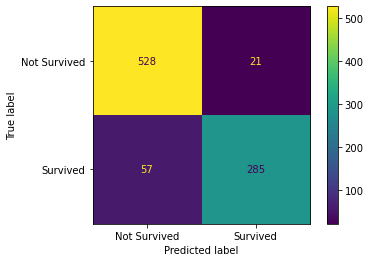

In [74]:
plot_confusion_matrix(rf, X_train, y_train, display_labels=["Not Survived", "Survived"])

In the confusion matrix, we see that of the 528 + 21 = 549 people that did not survive, 528 (96%) were correctly classified. And of the 57 + 285 = 342 people that survived, 285 (83.3%) were correctly classified.

In [111]:
feature_importance = pd.DataFrame(pd.Series(rf.feature_importances_, index=X_train.columns))
feature_importance.columns=['importance']
feature_importance = fi.sort_values('importance', ascending=False)[:20]
feature_importance

,importance
Name_Title_Mr.,0.120869
Fare,0.115611
Sex_female,0.111425
Sex_male,0.111411
Name_Len,0.101496
Age,0.096958
Pclass_3,0.053095
Cabin_Lett_n,0.035506
Name_Title_Miss.,0.032041
Name_Title_Mrs.,0.028121


<AxesSubplot:xlabel='importance'>

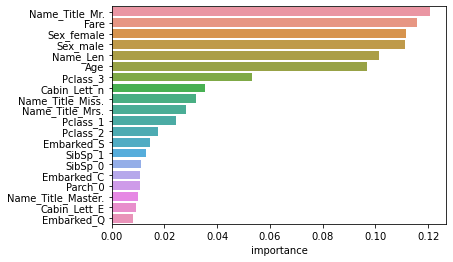

In [112]:

sns.barplot(x=feature_importance['importance'], y=feature_importance.index)

<a id="tune"></a>
# 7. Prediction

In [69]:
y_test = rf.predict(X_test)
result_dict = {'PassengerId': raw_test.PassengerId, 'Survived': y_test}
result_df = pd.DataFrame(result_dict)
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


<a id="result"></a>
# 8. Result & Explanation

In [ ]:
result_df.to_csv('/Users/KAI/Desktop/Data Scientists/Projects/Titanic/survival_prediction.csv', index =False)